# CDK2: Model Selection - y values shuffled
### Validation Method

In [2]:
import pandas as pd
import numpy as np
import glob, sys, os
sys.path.append('..')

In [3]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk', font_scale=0.8)

In [4]:
file_name = './df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
# Extract activity column
y_true_merged = X_merged_dksc['activity']
# Drop column from merged_dkksc
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape
y_true_merged.loc['DEKOIS'].sum()

40

## Scaffold Splitting

In [5]:
#*************************************************
# Functions to compute stratify scaffold splitting
#*************************************************
sys.path.append('../2_Docking_analysis/')
from scaffold_splitter import train_test_scaffold_split

In [6]:
# Compute or load the dataframe containing the Generic Murcko Scaffolds
file = '../2_Docking_analysis/df_COCRYS_DUD_DEKOIS_Murcko_Scaffolds_SMILES.obj'

df_scff_murcko = pd.read_pickle(file)
df_scff_murcko.shape

(6233, 3)

In [24]:
%run 4_Helper_Functions_Model_Selection_Grid_Search.ipynb

#  Hyperparameter Tunning: Grid Search

In [10]:
def randomize_y_labels(y_target, random_chi=0.1):
    '''Función para distribuir de forma aleatoria una fracción 
    chi del vector de etiquetas, de forma estratificada'''
    
    # Make a copy of the original vector
    y_copy = y.copy()
    
    # Get the number of actives inside the y_target vector
    n_actives = y_target.sum()
    random_size = np.floor(random_chi * n_actives)
    # Initialize the counters
    act_count = random_size
    inact_count = random_size
    
    # Create the randomized list of idexes
    idx_shuffled = np.random.choice(range(len(y)), len(y), replace=False)
    # iterate over idx_shuffled until act and inact counters == 0
    for l in idx_shuffled:
        if act_count > 0:
            if y_copy[l] == 1: # Is active, then change it to inactive
                y_copy[l] = 0
                act_count = act_count - 1
                continue
            if inact_count > 0: # If is inactive, change it to active
                y_copy[l] = 1
                inact_count = inact_count - 1
                continue
        else:
            break
    return(y_copy)
    

***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    Merged libraries: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DEKOIS, DUD and COCRYS are  treated as one unique library
#### Target values (y) will be shuffled

In [14]:
# Train and test over 
X = X_merged_dksc
# ***** Permutate y values *****
y = y_true_merged#.sample(frac=1, replace=False)

library = 'Merged'
scaffold_series = df_scff_murcko['scff_generic']

# Create an empty dictionary to save results

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [25]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
#     print('*'*60, '\n', 'Randomized y fraction (actives):', chi)
#     print('Number of actives/inactives shuffled:', chi*y.sum())
#     print('*'*60)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None, verbose=False)
    
    print('\n')

LogReg_chi0 => Train: Merged; Test: Merged; split: random


LogReg_chi0.1 => Train: Merged; Test: Merged; split: random


LogReg_chi0.2 => Train: Merged; Test: Merged; split: random


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 23, in <module>
  File "<ipython-input-24-810a3e3d2149>", line 11, in wrapper
    results = func(*args, **kwargs)
  File "<ipython-input-24-810a3e3d2149>", line 56, in split_and_gs
    hyperparams = hyperparams,  verbose=verbose, **kwargs)
  File "<ipython-input-24-7043bb5aff7c>", line 23, in run_grid_search
    gs.fit(X_train, y_train)
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1188, in _run_search
    evalu

TypeError: object of type 'NoneType' has no len()

In [10]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*60, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*60)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # SCAFFOLD Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='scaffold', test_size=0.25, 
                 scaffold_series=scaffold_series)

************************************************************ 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
************************************************************
LogReg_chi0 => Train: Merged; Test: Merged; split: scaffold
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.818
- Train ROC-AUC:  	0.903
- Test ROC-AUC:   	0.745
- Best hyperparameters {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.687 	> median: 0.594, mean: 0.593
> Test best conf. ROC-AUC: 0.716 	> median: 0.654, mean: 0.647
****************************************************************
************************************************************ 
 Randomized y fraction (actives): 0.1
Number of actives/inactives shuffled: 30.0
*

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: X Gradient Boosting </h3>
<b>Merged Libraries</b>

In [11]:
%%time

from xgboost import XGBClassifier

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)
    
    estimator_name = 'XGB_tree'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = XGBClassifier()
    hyperparams = {'n_estimators': [200, 300],
                   'max_depth': [2, 3, 10, 20],
                   'learning_rate': [0.05, 0.1],
                   'gamma': [0.01, 0.1, 0.5, 1],
                   'alpha': [0.01, 0.1, 0.5, 1],
                   'subsample': [0.3, 0.5],
                   'colsample_bytree': [0.3, 0.5, 1]
                }

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None,
                 # RandomizedGS
                 randomGS=True, n_iter=30)
    
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
XGB_tree_chi0 => Train: Merged; Test: Merged; split: random
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.869
- Train ROC-AUC:  	1.000
- Test ROC-AUC:   	0.900
- Best hyperparameters {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 1, 'alpha': 0.5}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.690 	> median: 0.615, mean: 0.613
> Test best conf. ROC-AUC: 0.689 	> median: 0.590, mean: 0.590
****************************************************************


*********************

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Radial Basis Function SVM</h3>
<b>Merged Libraries</b>

In [12]:
%%time
from sklearn.svm import SVC

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    estimator_name = 'rbfSVC'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = SVC(kernel = 'rbf', probability=True)
    hyperparams = {'C': [1]} #{'C': np.geomspace(1e0, 1e2, 3), 'gamma': np.geomspace(1e-4, 1e0, 3)}

    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None)
    
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
rbfSVC_chi0 => Train: Merged; Test: Merged; split: random
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.851
- Train ROC-AUC:  	0.956
- Test ROC-AUC:   	0.865
- Best hyperparameters {'C': 1}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.669 	> median: 0.601, mean: 0.599
> Test best conf. ROC-AUC: 0.726 	> median: 0.637, mean: 0.632
****************************************************************


******************************************************************************** 
 Randomized y fraction (actives): 0.1
Number of actives/inactive

In [13]:
%%time

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    estimator_name = 'rbfSVC'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = SVC(kernel = 'rbf', probability=True)
    hyperparams = {'C': np.geomspace(1e0, 1e2, 3), 'gamma': [0, 1, 10]}
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)
    
    # SCAFFOLD Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='scaffold', test_size=0.25, 
                 scaffold_series=scaffold_series)
    
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
rbfSVC_chi0 => Train: Merged; Test: Merged; split: scaffold
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.833
- Train ROC-AUC:  	0.966
- Test ROC-AUC:   	0.718
- Best hyperparameters {'C': 1}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.687 	> median: 0.594, mean: 0.593
> Test best conf. ROC-AUC: 0.716 	> median: 0.654, mean: 0.647
****************************************************************


******************************************************************************** 
 Randomized y fraction (actives): 0.1
Number of actives/inacti

<h3 style='color: #F84122; padding: 0px;; margin:ade0px'>GS: kNN Calssifier </h3>
<b>Merged Libraries</b>

In [14]:
%%time
from sklearn.neighbors import KNeighborsClassifier 


for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    estimator_name = '1-NN'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = KNeighborsClassifier()
    hyperparams = {'n_neighbors': [1], 
                   'p': [1, 2]
                     }
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None)
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
1-NN_chi0 => Train: Merged; Test: Merged; split: random
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.712
- Train ROC-AUC:  	1.000
- Test ROC-AUC:   	0.711
- Best hyperparameters {'n_neighbors': 1, 'p': 1}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.685 	> median: 0.605, mean: 0.604
> Test best conf. ROC-AUC: 0.694 	> median: 0.622, mean: 0.618
****************************************************************


******************************************************************************** 
 Randomized y fraction (actives): 0.1
Number of 

In [15]:
%%time
from sklearn.neighbors import KNeighborsClassifier 


for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    estimator_name = '1-NN'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = KNeighborsClassifier()
    hyperparams = {'n_neighbors': [1], 
                   'p': [1, 2]
                     }
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                splitting='scaffold', test_size=0.25, 
                 scaffold_series=scaffold_series) 
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
1-NN_chi0 => Train: Merged; Test: Merged; split: scaffold
No. of molecules in train set: 4674, with 225 actives.
No. of molecules in test set: 1559, with 75 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.628
- Train ROC-AUC:  	1.000
- Test ROC-AUC:   	0.581
- Best hyperparameters {'n_neighbors': 1, 'p': 1}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.687 	> median: 0.594, mean: 0.593
> Test best conf. ROC-AUC: 0.716 	> median: 0.654, mean: 0.647
****************************************************************


******************************************************************************** 
 Randomized y fraction (actives): 0.1
Number o

***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    DEKOIS: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DEKOIS 
#### Target values (y) will be shuffled

In [16]:
library = 'DEKOIS'

# Train and test over DUDU
X = X_merged_dksc.loc[library]
y = y_true_merged.loc[library]
scaffold_series = df_scff_murcko['scff_generic'].loc[library]

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [17]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None)
    
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
LogReg_chi0 => Train: DEKOIS; Test: DEKOIS; split: random
No. of molecules in train set: 915, with 30 actives.
No. of molecules in test set: 306, with 10 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.893
- Train ROC-AUC:  	0.924
- Test ROC-AUC:   	0.866
- Best hyperparameters {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.903 	> median: 0.851, mean: 0.844
> Test best conf. ROC-AUC: 0.895 	> median: 0.792, mean: 0.790
****************************************************************


******************************************************************************** 
 Randomized y fraction (acti

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


No. of molecules in train set: 915, with 30 actives.
No. of molecules in test set: 306, with 10 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.728
- Train ROC-AUC:  	0.997
- Test ROC-AUC:   	0.498
- Best hyperparameters {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.732 	> median: 0.672, mean: 0.669
> Test best conf. ROC-AUC: 0.714 	> median: 0.641, mean: 0.635
****************************************************************


******************************************************************************** 
 Randomized y fraction (actives): 0.5
Number of actives/inactives shuffled: 20.0
********************************************************************************
LogReg_chi0.5 => Train: DEKOIS; Test: DEKOIS; split: random
No. of molecules in train set: 915, with 30 actives.
No. of molecules in test set: 306, with 10 actives.

In [18]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # SCAFFOLD Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='scaffold', test_size=0.25, 
                 scaffold_series=scaffold_series)

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
LogReg_chi0 => Train: DEKOIS; Test: DEKOIS; split: scaffold
No. of molecules in train set: 915, with 30 actives.
No. of molecules in test set: 306, with 10 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.866
- Train ROC-AUC:  	0.870
- Test ROC-AUC:   	0.950
- Best hyperparameters {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.883 	> median: 0.816, mean: 0.811
> Test best conf. ROC-AUC: 0.967 	> median: 0.897, mean: 0.893
****************************************************************
******************************************************************************** 
 Randomized y fraction (ac

***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    DUD: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DUD 
#### Target values (y) will be shuffled

In [19]:
library = 'DUD'

# Train and test over DUDU
X = X_merged_dksc.loc[library]
y = y_true_merged.loc[library]
scaffold_series = df_scff_murcko['scff_generic'].loc[library]

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [20]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # RANDOM Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='random', test_size=0.25, 
                 scaffold_series=None)
    
    print('\n')

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
LogReg_chi0 => Train: DUD; Test: DUD; split: random
No. of molecules in train set: 3669, with 106 actives.
No. of molecules in test set: 1224, with 35 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.849
- Train ROC-AUC:  	0.931
- Test ROC-AUC:   	0.855
- Best hyperparameters {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.710 	> median: 0.556, mean: 0.556
> Test best conf. ROC-AUC: 0.780 	> median: 0.610, mean: 0.616
****************************************************************


******************************************************************************** 
 Randomized y fraction (acti

In [21]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    y_rd = randomize_y_labels(y, chi)
    
    print('*'*80, '\n', 'Randomized y fraction (actives):', chi)
    print('Number of actives/inactives shuffled:', chi*y.sum())
    print('*'*80)

    estimator_name = 'LogReg'
    estimator_name = estimator_name + '_chi' + str(chi)
    estimator = LogisticRegression(max_iter=300)
    hyperparams = {'C':  np.geomspace(1e-8, 1e2, 6),
                   'penalty': ['l1', 'l2'], 
                   'solver': ['lbfgs', 'liblinear']}

    # SCAFFOLD Train test splitting
    split_and_gs(library, library, estimator_name,
                 X, y_rd, estimator, hyperparams,
                 splitting='scaffold', test_size=0.25, 
                 scaffold_series=scaffold_series)

******************************************************************************** 
 Randomized y fraction (actives): 0
Number of actives/inactives shuffled: 0
********************************************************************************
LogReg_chi0 => Train: DUD; Test: DUD; split: scaffold
No. of molecules in train set: 3669, with 105 actives.
No. of molecules in test set: 1224, with 36 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC:	0.887
- Train ROC-AUC:  	0.967
- Test ROC-AUC:   	0.637
- Best hyperparameters {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
******************************************

***** Best Conformation's ROC-AUC using docking scores *****
> Train best conf. ROC-AUC: 0.747 	> median: 0.545, mean: 0.547
> Test best conf. ROC-AUC: 0.718 	> median: 0.636, mean: 0.634
****************************************************************
******************************************************************************** 
 Randomized y fraction (acti

# Results

In [22]:

row_names = ['Train_set', 'Test_set', 'Model name', 'Split', 
             'N_actives_train', 'N_actives_test', 'N_mols_train', 'Num_mols_test',
            'Mean-CV-ROC', 'ROC-AUC_train', 'ROC-AUC_test', 'best_params',
            'DkS_max_ROC_train',  'DkSc_med_ROC_train', 'DkSc_mean_ROC_train', 
            'DkS_max_ROC_test',  'DkSc_med_ROC_test', 'DkSc_mean_ROC_test'
            ]


y_shuffled_ml_model_selecion = pd.DataFrame(results_dict, index = row_names).T
y_shuffled_ml_model_selecion.to_pickle('df_y_shuffled_ml_model_selecion.pkl')

In [1]:
# y_shuffled_ml_model_selecion

## Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style=None, font_scale=0.8)
import warnings
warnings.filterwarnings("ignore")
y_shuffled_ml_model_selecion = pd.read_pickle('./df_y_shuffled_ml_model_selecion.pkl')

# Create a column to indicate the chi value
df = y_shuffled_ml_model_selecion
df['chi'] =  df['Model name'].str.split('_chi').str[1]
df['Model name'] = df['Model name'].str.split('_').str[0]
df = df.reset_index(drop=True)
df.set_index(['Train_set', 'Test_set', 'Model name', 'Split'], inplace=True)
df = df.sort_index(level=1, axis=1)

In [3]:
def plot_results(db, split):
    for ml_clf in df.index.get_level_values(2).unique():
        idx = (db, db, ml_clf, split)
        roc_cols = ['Mean-CV-ROC', 'ROC-AUC_train', 'ROC-AUC_test']
        try:
            df.loc[idx].plot(x='chi', 
                             y=roc_cols, 
                             figsize=(10,6),
                             ylim=(0.2, 1.01), 
                             title=db + '-' + split + '-' + ml_clf)
            plt.xlabel('Randomized fraction')
            plt.ylabel('ROC-AUC')
            plt.grid(True)
            plt.axhline(y=0.5, color='black', linestyle=':')
        except: None

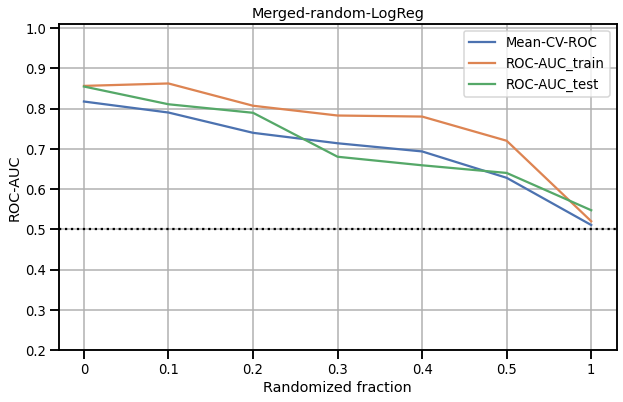

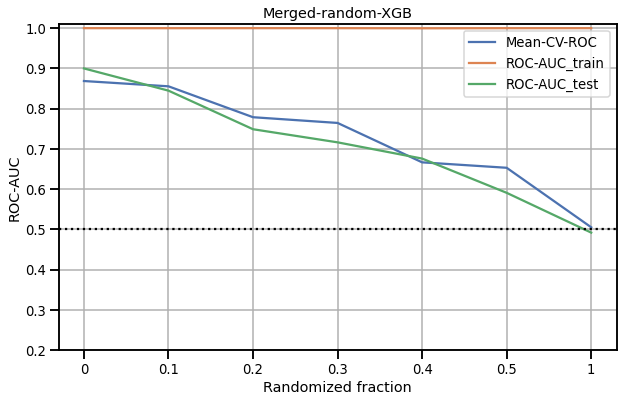

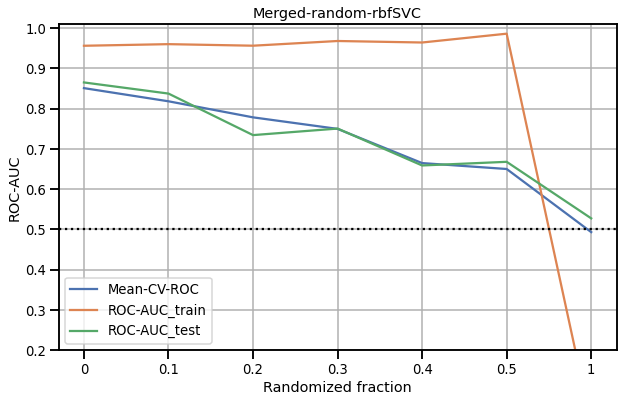

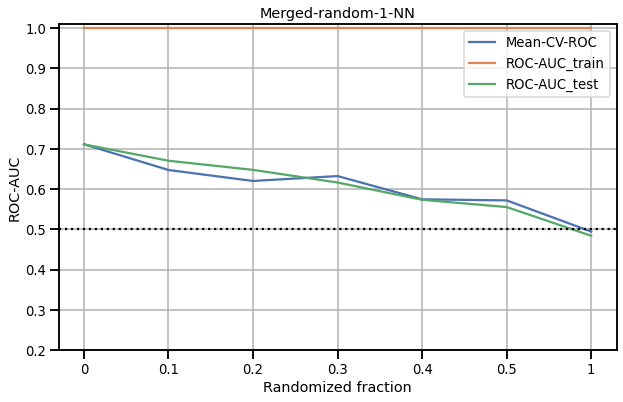

In [4]:
plot_results('Merged', 'random')

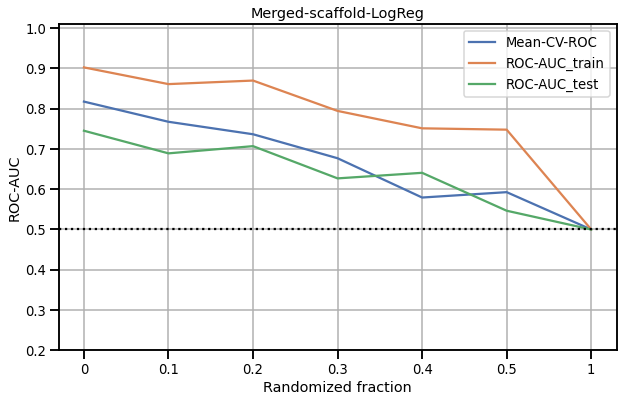

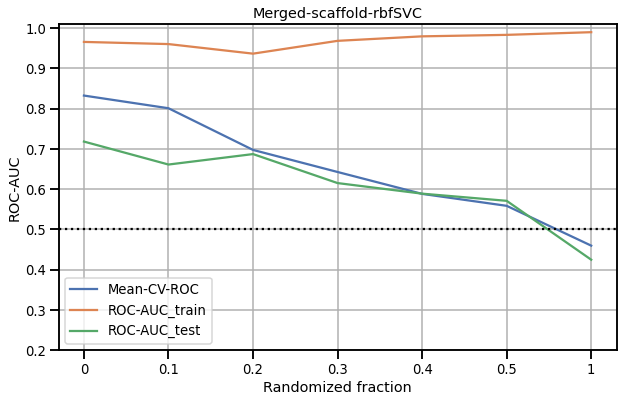

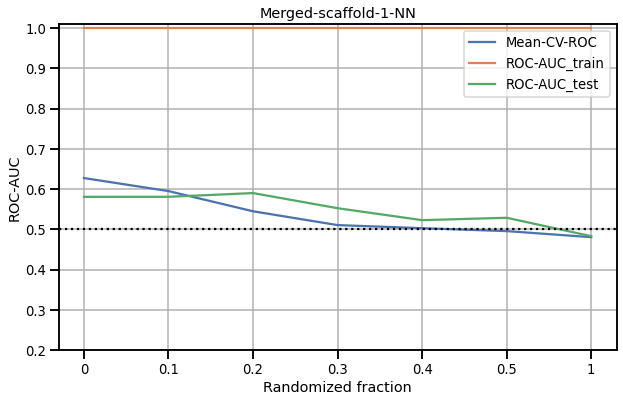

In [5]:
plot_results('Merged', 'scaffold')

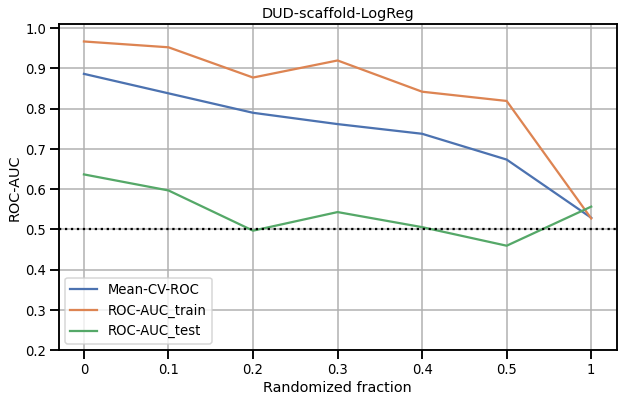

In [10]:
plot_results('DUD', 'scaffold')

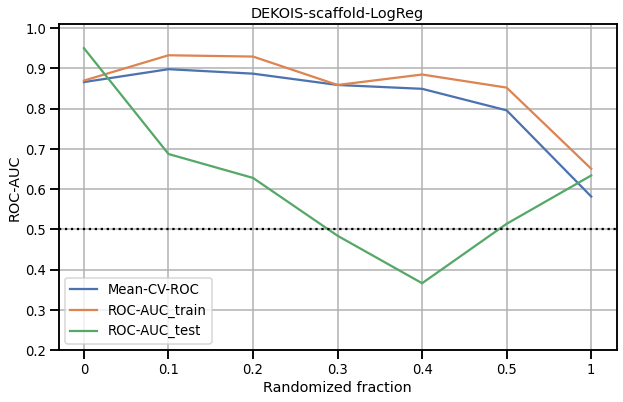

In [9]:
plot_results('DEKOIS', 'scaffold')